In [1]:
import numpy as np
import astropy.units as u
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from astropy.coordinates import EarthLocation, AltAz

In [3]:
import pandas as pd

In [4]:
import seaborn as sns

In [5]:
aartfaac = EarthLocation(
    EarthLocation(lat=52.9153 * u.deg, lon=6.8698 * u.deg, height=20 * u.m)
)

In [6]:
camsdata = pd.read_fwf(
    "../SummaryMeteorLog CAMS Benelux 120820 .txt",
    index_col=0,
    header=[0, 1],
    skip_blank_lines=True,
    skiprows=[2],
    skipinitialspace=True,
)

In [7]:
camsdata.columns = [
    " ".join(col) if isinstance(col, tuple) else col for col in camsdata.columns
]

In [8]:
camsdata["astropytime_beg"] = (
    Time(list(camsdata["Observed Date"] + " " + camsdata["Ref Time UT"]))
    + np.array(camsdata["Tbeg sec"]) * u.s
)
camsdata["astropytime_end"] = (
    Time(list(camsdata["Observed Date"] + " " + camsdata["Ref Time UT"]))
    + np.array(camsdata["Tend sec"]) * u.s
)

In [9]:
aartfaac_altaz = AltAz(
    location=EarthLocation(
        lat=camsdata["LatBeg +N deg"].values * u.deg,
        lon=camsdata["LonBeg +E deg"].values * u.deg,
    ),
    distance=camsdata["Hbeg km"].values * u.km,
    az=0 * u.deg,
    alt=90 * u.deg,
    obstime=camsdata["astropytime_beg"]
).transform_to(AltAz(location=aartfaac, obstime=camsdata["astropytime_beg"]))

In [10]:
camsdata["aartfaac_alt deg"] = aartfaac_altaz.alt.deg

In [11]:
# Remove duplicates from camsdata
camsdata = camsdata.drop([58, 72, 172, 515, 528, 690])

In [12]:
camsdata = camsdata.join(pd.read_csv("aartfaac-cams-matches.csv", index_col=0))
camsdata = camsdata.join(pd.read_csv("sap0-cams-matches.csv", index_col=0))
camsdata = camsdata.join(pd.read_csv("sap1-cams-matches.csv", index_col=0))
camsdata = camsdata.join(pd.read_csv("radioheight_perseids.csv", index_col=0))
camsdata = camsdata.join(pd.read_csv("radioflux_perseids.csv", index_col=0))

In [13]:
# Trails longer than 60 seconds
camsdata[camsdata["AARTFAAC_duration"] > 60][
    ["astropytime_beg", "Max-mV mag", "AARTFAAC_duration", "SAP0_match", "SAP1_match"]
]

,astropytime_beg,Max-mV mag,AARTFAAC_duration,SAP0_match,SAP1_match
77,2020-08-12 21:25:48.310,-17.7,132.0,1.0,2.0
123,2020-08-12 21:57:18.680,-10.8,84.0,2.0,2.0
241,2020-08-12 23:03:30.080,-6.3,122.0,2.0,2.0
309,2020-08-12 23:36:05.410,-4.3,90.0,1.0,NaN
319,2020-08-12 23:44:07.300,-4.1,108.0,2.0,2.0
352,2020-08-13 00:11:26.200,-7.0,396.0,2.0,2.0
527,2020-08-13 01:41:22.920,-22.7,94.0,1.0,1.0
527,2020-08-13 01:41:22.920,-22.7,94.0,1.0,2.0
698,2020-08-13 02:57:38.180,-10.3,122.0,1.0,2.0
716,2020-08-13 03:07:45.660,-5.4,108.0,NaN,1.0


In [14]:
# CAMS IDs of meteors visible longer than 3 seconds
str(list(camsdata[camsdata["AARTFAAC_duration"] > 3].index))

'[52, 54, 57, 59, 60, 65, 66, 74, 75, 77, 82, 92, 101, 102, 103, 115, 123, 128, 142, 144, 146, 147, 151, 154, 175, 235, 241, 249, 253, 254, 255, 263, 270, 276, 277, 278, 283, 285, 288, 295, 296, 297, 309, 315, 317, 319, 320, 322, 323, 327, 329, 332, 333, 344, 351, 352, 353, 360, 361, 369, 370, 374, 377, 385, 391, 393, 404, 408, 411, 417, 418, 419, 436, 437, 440, 447, 452, 454, 471, 480, 484, 485, 489, 491, 492, 495, 497, 501, 505, 507, 509, 514, 516, 517, 524, 527, 527, 529, 535, 537, 545, 549, 554, 556, 561, 565, 573, 579, 589, 596, 598, 600, 601, 605, 612, 614, 616, 617, 635, 638, 639, 641, 643, 644, 645, 647, 659, 661, 671, 677, 679, 683, 688, 692, 696, 698, 702, 704, 705, 706, 707, 714, 716, 718, 719, 723, 726, 729, 732, 735, 736, 737]'

In [15]:
camsdata["Vinf km/sec"].std()

9.11014725749413

In [16]:
camsdata["Is_Perseid"] = (
    (camsdata["Vinf km/sec"] > 60.0 - 15)
    & (camsdata["Vinf km/sec"] < 60.0 + 15)
    & (camsdata["DECinf deg"] > 58.12 - 10)
    & (camsdata["DECinf deg"] < 58.12 + 10)
    & (camsdata["RAinf deg"] > 48.14 - 10)
    & (camsdata["RAinf deg"] < 48.14 + 10)
)

In [17]:
camsdata[(~camsdata["Is_Perseid"]) & (camsdata["AARTFAAC"] > 0)].sort_values(
    "Int-mV mag"
)[["astropytime_beg", "Max-mV mag", "AARTFAAC_duration", "SAP0_match", "SAP1_match"]]

,astropytime_beg,Max-mV mag,AARTFAAC_duration,SAP0_match,SAP1_match
123,2020-08-12 21:57:18.680,-10.8,84.0,2.0,2.0
514,2020-08-13 01:35:07.720,-5.4,14.0,NaN,NaN
529,2020-08-13 01:41:49.820,-2.1,32.0,1.0,1.0
485,2020-08-13 01:23:14.070,-2.9,6.0,NaN,NaN
605,2020-08-13 02:18:04.390,-3.5,42.0,NaN,NaN
377,2020-08-13 00:26:50.230,-2.9,14.0,2.0,2.0
385,2020-08-13 00:30:49.620,-2.1,14.0,NaN,NaN
601,2020-08-13 02:16:58.880,-1.0,28.0,2.0,2.0
524,2020-08-13 01:40:46.240,-1.7,6.0,1.0,1.0
675,2020-08-13 02:46:28.060,-2.2,2.0,NaN,NaN


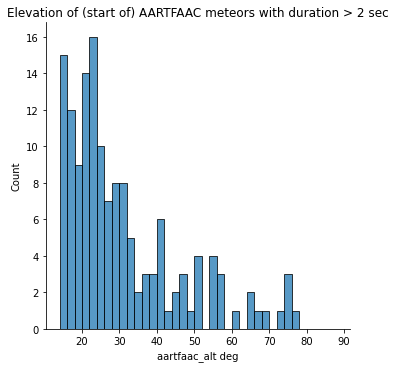

In [18]:
sns.displot(
    camsdata[camsdata["AARTFAAC_duration"] > 2]["aartfaac_alt deg"], bins=np.arange(14,90,2)
)
plt.title("Elevation of (start of) AARTFAAC meteors with duration > 2 sec");

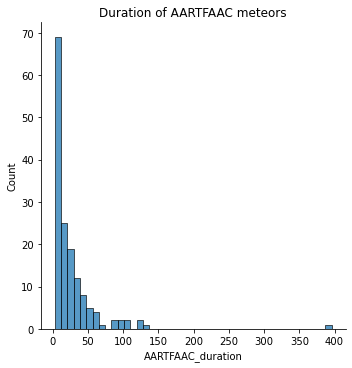

In [19]:
sns.displot(
    camsdata[
        camsdata["AARTFAAC_duration"].notnull() & (camsdata["AARTFAAC_duration"] > 2)
    ],
    x="AARTFAAC_duration",
)
plt.title("Duration of AARTFAAC meteors");

In [20]:
aartfaacmatch = camsdata["AARTFAAC"] > 0
camsdata["AARTFAAC_match"] = False
camsdata.loc[aartfaacmatch, "AARTFAAC_match"] = "With AARTFAAC match"

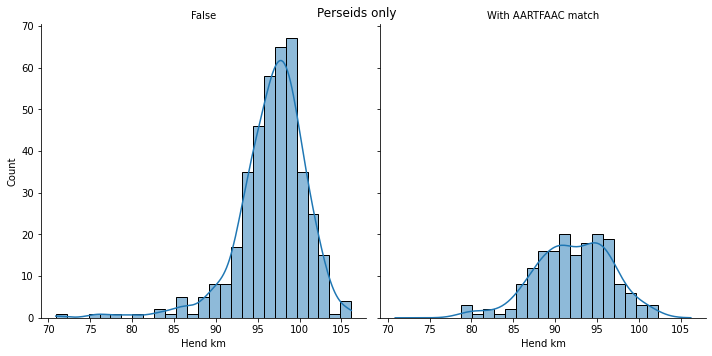

In [21]:
g = sns.displot(
    camsdata[camsdata["Is_Perseid"]], x="Hend km", col="AARTFAAC_match", kde=True
)
g.set_titles("{col_name}")
plt.suptitle("Perseids only");

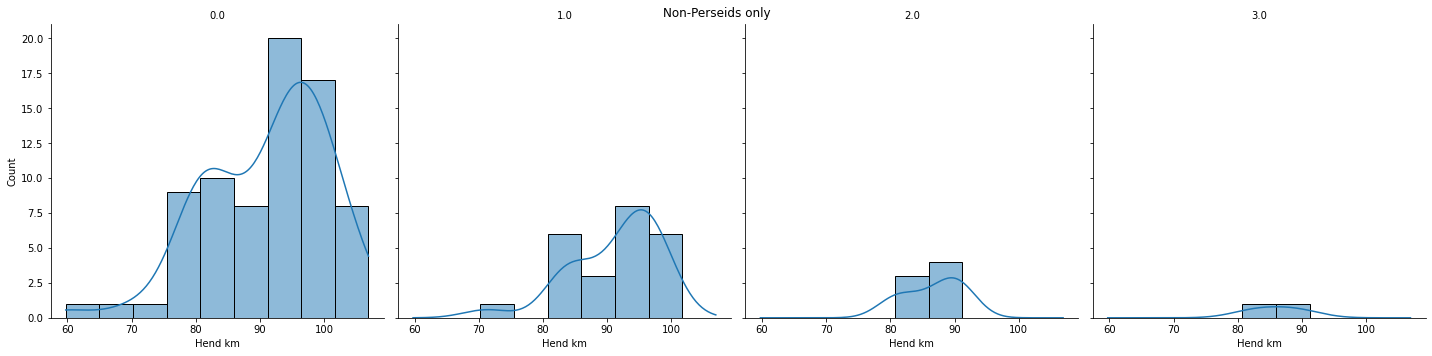

In [22]:
g = sns.displot(
    camsdata[~camsdata["Is_Perseid"]], x="Hend km", col="AARTFAAC", kde=True
)
g.set_titles("{col_name}")
plt.suptitle("Non-Perseids only");

In [23]:
camsdata.groupby(["AARTFAAC_match", "Is_Perseid"]).size()

AARTFAAC_match       Is_Perseid
False                False         109
                     True          403
With AARTFAAC match  False          33
                     True          173
dtype: int64

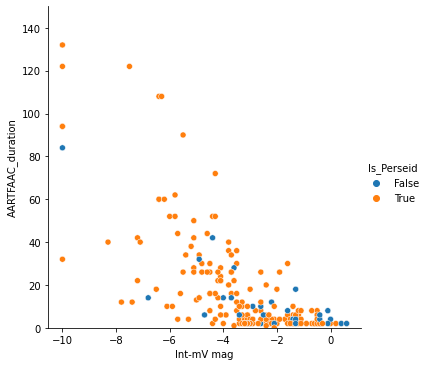

In [24]:
camsdata.loc[camsdata["Int-mV mag"] < -10, "Int-mV mag"] = -10
sns.relplot(x="Int-mV mag", y="AARTFAAC_duration", data=camsdata, hue="Is_Perseid")
plt.ylim(0, 150);

In [60]:
camsdata.columns

Index(['Observed Date', 'Ref Time UT', 'Tbeg sec', 'Tend sec', 'RAinf deg',
       '+/- sigma', 'DECinf deg', '+/- sigma.1', 'Vinf km/sec', '+/- sigma.2',
       'Acc1 Unnamed: 11_level_1', '+/- sigma.3', 'Acc2 Unnamed: 13_level_1',
       '+/- sigma.4', 'LatBeg +N deg', '+/- sigma.5', 'LonBeg +E deg',
       '+/- sigma.6', 'Hbeg km', '+/- sigma.7', 'LatEnd +N deg', '+/- sigma.8',
       'LonEnd +E deg', '+/- sigma.9', 'Hend km', '+/- sigma.10', 'Conv deg',
       'S-Azim +W deg', 'ZenAng deg', 'Hmax km', 'Max-mV mag', 'Int-mV mag',
       'F-skew Hratio', 'Cameras Contributing', 'astropytime_beg',
       'astropytime_end', 'aartfaac_alt deg', 'AARTFAAC', 'AARTFAAC_duration',
       'SAP0_match', 'SAP1_match', 'x0', 'x1', 'xbeg', 'xend', 'hbeg_radio',
       'hend_radio', 'fitsfile_with_detection_beg',
       'fitsfile_with_detection_end', 'radio_maxflux', 'fitsfile_max',
       'Is_Perseid', 'AARTFAAC_match', 'radio_maxflux_log'],
      dtype='object')

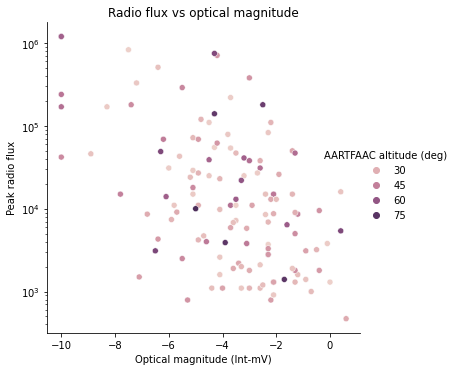

In [160]:
camsdata.loc[camsdata["Int-mV mag"] < -10, "Int-mV mag"] = -10
fg = sns.relplot(x="Int-mV mag", y="radio_maxflux", data=camsdata[camsdata['aartfaac_alt deg'] > 20], hue="aartfaac_alt deg")
ax = fg.axes[0, 0]
fg._legend.set_title("AARTFAAC altitude (deg)")
ax.set_yscale('log');
ax.set_title("Radio flux vs optical magnitude");
ax.set_xlabel("Optical magnitude (Int-mV)")
ax.set_ylabel("Peak radio flux");

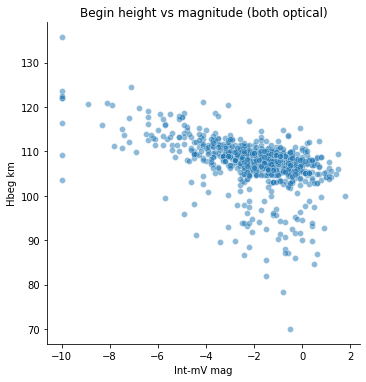

In [150]:
camsdata.loc[camsdata["Int-mV mag"] < -10, "Int-mV mag"] = -10
fg = sns.relplot(x="Int-mV mag", y="Hbeg km", data=camsdata, alpha=0.5)
ax = fg.axes[0, 0]
ax.set_title("Begin height vs magnitude (both optical)");

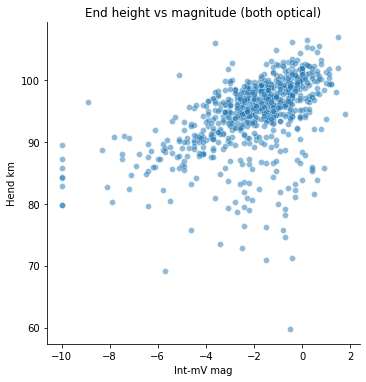

In [149]:
camsdata.loc[camsdata["Int-mV mag"] < -10, "Int-mV mag"] = -10
fg = sns.relplot(x="Int-mV mag", y="Hend km", data=camsdata, alpha=0.5)
ax = fg.axes[0, 0]
ax.set_title("End height vs magnitude (both optical)");

In [128]:
camsdata["radio_maxflux_log"] = np.log(camsdata["radio_maxflux"])

In [129]:
camsdata.columns

Index(['Observed Date', 'Ref Time UT', 'Tbeg sec', 'Tend sec', 'RAinf deg',
       '+/- sigma', 'DECinf deg', '+/- sigma.1', 'Vinf km/sec', '+/- sigma.2',
       'Acc1 Unnamed: 11_level_1', '+/- sigma.3', 'Acc2 Unnamed: 13_level_1',
       '+/- sigma.4', 'LatBeg +N deg', '+/- sigma.5', 'LonBeg +E deg',
       '+/- sigma.6', 'Hbeg km', '+/- sigma.7', 'LatEnd +N deg', '+/- sigma.8',
       'LonEnd +E deg', '+/- sigma.9', 'Hend km', '+/- sigma.10', 'Conv deg',
       'S-Azim +W deg', 'ZenAng deg', 'Hmax km', 'Max-mV mag', 'Int-mV mag',
       'F-skew Hratio', 'Cameras Contributing', 'astropytime_beg',
       'astropytime_end', 'aartfaac_alt deg', 'AARTFAAC', 'AARTFAAC_duration',
       'SAP0_match', 'SAP1_match', 'x0', 'x1', 'xbeg', 'xend', 'hbeg_radio',
       'hend_radio', 'fitsfile_with_detection_beg',
       'fitsfile_with_detection_end', 'radio_maxflux', 'fitsfile_max',
       'Is_Perseid', 'AARTFAAC_match', 'radio_maxflux_log'],
      dtype='object')

In [164]:
a = camsdata['radio_maxflux'].sort_values(ascending=False)[:50].index
b = (camsdata['hbeg_radio'] - camsdata['hend_radio']).sort_values(ascending=False)[:30].index
c = (camsdata['aartfaac_alt deg'] > 20).index
camsdata_selection = camsdata.loc[intersection]
camsdata_selection[['aartfaac_alt deg', 'AARTFAAC_duration', 'radio_maxflux', 'hbeg_radio', 'hend_radio', 'astropytime_beg', 'fitsfile_max']]

,aartfaac_alt deg,AARTFAAC_duration,radio_maxflux,hbeg_radio,hend_radio,astropytime_beg,fitsfile_max
352,24.237210,396.0,46000.0,106.279,82.731,2020-08-13 00:11:26.200,2020-08-13T00:14:26.8_13B.fits
545,21.436229,30.0,110000.0,105.618,87.341,2020-08-13 01:46:22.710,2020-08-13T01:46:40.2_14B.fits
549,22.843668,40.0,79000.0,102.719,81.945,2020-08-13 01:47:10.930,2020-08-13T01:47:24.5_15B.fits
440,24.973151,60.0,510000.0,101.897,85.403,2020-08-13 00:59:34.750,2020-08-13T01:00:19.9_14B.fits
489,13.276065,8.0,330000.0,103.276,85.984,2020-08-13 01:25:34.910,2020-08-13T01:25:37.9_14B.fits
556,13.781355,22.0,420000.0,100.835,86.247,2020-08-13 01:51:46.210,2020-08-13T01:51:50.3_15B.fits
77,47.896941,132.0,240000.0,105.621,88.663,2020-08-12 21:25:48.310,2020-08-12T21:25:57.7_14B.fits
527,55.665784,94.0,1200000.0,102.008,75.350,2020-08-13 01:41:22.920,2020-08-13T01:41:44.3_12B.fits
527,55.665784,94.0,1200000.0,102.008,75.350,2020-08-13 01:41:22.920,2020-08-13T01:41:44.3_12B.fits
601,17.986765,28.0,91000.0,102.940,80.376,2020-08-13 02:16:58.880,2020-08-13T02:17:06.2_14B.fits


In [168]:
camsdata_selection.index

Int64Index([352, 545, 549, 440, 489, 556,  77, 527, 527, 601, 147, 309, 344,
            249, 154, 283, 319],
           dtype='int64')

In [166]:
timeslots = []
for rownr, row in camsdata_selection.iterrows():
    timeslots.appens[]

SyntaxError: unexpected EOF while parsing (<ipython-input-166-ed82e190bed6>, line 1)

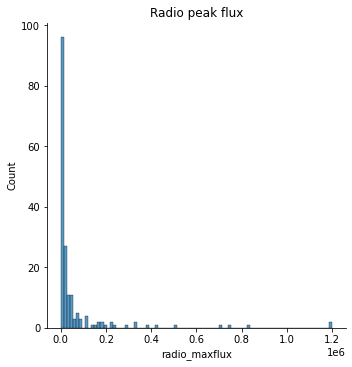

In [161]:
fg = sns.displot(
    camsdata[
        ~camsdata["radio_maxflux"].isnull()
    ],
    x="radio_maxflux",
)
plt.title("Radio peak flux");

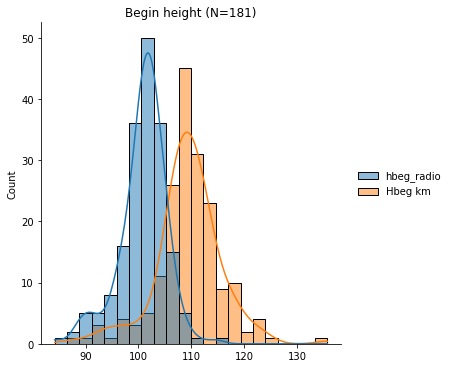

In [154]:
data = camsdata[camsdata["hbeg_radio"] > 0][["hbeg_radio", "Hbeg km"]]
fg = sns.displot(
    data=data, kde=True
);
fg.axes[0, 0].set_title(f"Begin height (N={len(data)})");

In [152]:
fg._legend

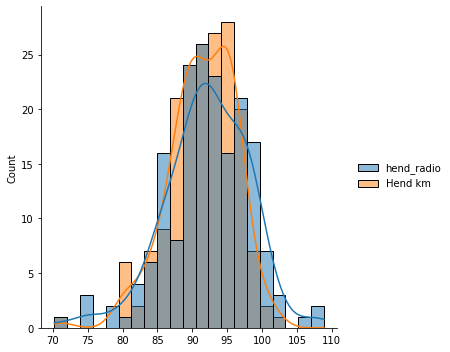

In [156]:
data = camsdata[camsdata["hend_radio"] > 0][["hend_radio", "Hend km"]];
sns.displot(
    data=data, kde=True
);
fg.axes[0, 0].set_title(f"End height (N={len(data)})");

In [25]:
cameralist = ''.join(camsdata["Cameras Contributing"].values).split('_')[1:]
meteors_per_camera = {camera: cameralist.count(camera) for camera in cameralist}

In [26]:
"','".join(set(cameralist))

"003166','000376','000394','000322','000314','000389','003163','000822','003850','000320','000804','003164','003814','000388','000352','000391','000399','000381','000372','000377','003034','000347','000393','000326','000808','003162','000321','003000','003033','000382','003831','003800','000397','000318','000811','000821','000395','000396','000371','003036','000348','000351','000383','000378','000324','000384','000801','003165','000888','003002','000380','000390','003167','003001','003852','000805','000373','003031','000325','000328','003004','000327','000354','000329','000809','000807','003032','000813','003030','000810','003003','003037','000323','003035','000311','000812','000379','003161','003005','000317','000398','000806','000816','000353','000802','000803"

In [30]:
meteors_per_camera

{'003166': 35,
 '000388': 29,
 '000324': 33,
 '003033': 25,
 '003003': 55,
 '003165': 30,
 '000813': 44,
 '000373': 26,
 '003035': 38,
 '003005': 52,
 '000812': 76,
 '000323': 29,
 '000822': 59,
 '003004': 44,
 '003163': 16,
 '000399': 33,
 '000384': 43,
 '000322': 25,
 '000347': 29,
 '000321': 27,
 '000383': 27,
 '000351': 52,
 '003167': 34,
 '003001': 29,
 '003002': 27,
 '000320': 30,
 '000327': 32,
 '000353': 47,
 '000317': 37,
 '000311': 20,
 '000314': 29,
 '000354': 29,
 '000325': 18,
 '000326': 22,
 '000376': 13,
 '003000': 33,
 '000348': 31,
 '000371': 42,
 '003162': 23,
 '000888': 18,
 '000821': 22,
 '003161': 28,
 '000806': 26,
 '000329': 64,
 '000352': 51,
 '000372': 21,
 '000801': 11,
 '000328': 47,
 '000807': 15,
 '000397': 15,
 '000377': 13,
 '003034': 11,
 '000318': 27,
 '000390': 26,
 '000398': 1,
 '000805': 12,
 '000809': 17,
 '003831': 25,
 '000378': 58,
 '003031': 13,
 '000391': 32,
 '000393': 26,
 '003036': 9,
 '000802': 23,
 '003030': 5,
 '000816': 39,
 '003164': 8,